In [1]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
from began.visualization import plot, mplot
from scipy.ndimage import gaussian_filter
from began.optimization import get_l2_loss_and_gradient_function
print("Running on GPU: ", tf.test.is_gpu_available())

Running on GPU:  True


Minimizing a tensorflow model.

In [2]:
gen = tf.keras.models.load_model("/home/bthorne/projects/gan/began/models/generator.h5")

In [3]:
z_in = np.random.randn(1, 64)
ma = gen(z_in)

fwhm_in_pix = 120. / 5.
sigma = fwhm_in_pix / np.sqrt(8 * np.log(2))
print('Sigma:', sigma)
ma_smo = gaussian_filter(ma[0, :, :, 0], sigma)

Sigma: 10.191861603456228


In [4]:
fig, axes = mplot(np.concatenate((ma[..., 0], ma_smo[None, ...], gen_smo_prediction[..., 0])), extent=[-10, 10, -10, 10], xlabels=[r"$x$", r"$x$", r"$x$"], ylabels=[r"$y$", None, None])
titles = [r"$\mathbf{g}(\mathbf{z_{\rm in}})$", r"$\mathbf{B} \ast \mathbf{g}(\mathbf{z}) + \mathbf{n}$", r"$\mathbf{g}(\mathbf{z}_{\rm ML})$"]
for ax, title in zip(axes, titles):
    ax.set_title(title)
fig.savefig("plots/hyper-res-rec-g.pdf")

NameError: name 'gen_smo_prediction' is not defined

In [12]:
ax.set_xticklabels()

NameError: name 'ax' is not defined

In [13]:
import h5py
from pathlib import Path

In [14]:
#for my maps
RES = 256
STEP_SIZE = 4 
GAL_CUT = 16
record_dir = Path("../data/preprocessed/")
fpath = record_dir / "GNILC_dust_map_{:d}_st{:d}_gcut{:d}.npy".format(RES, int(STEP_SIZE), int(GAL_CUT))
train_images = np.load(fpath).astype(np.float32)
x_train = train_images[70, :, :, 0]

# for kevin's maps

#with h5py.File("/home/bthorne/projects/gan/began/data/preprocessed/Planck_dust_cuts_353GHz_norm_log_res256.h5", 'r') as f:
#    x_train = f['200'][:]
#x_train = np.array([i for i in f.values()]).reshape(-1, 256, 256, 1).astype(np.float32)
x_train_smo = gaussian_filter(x_train, sigma)

In [15]:
print(x_train.shape)

(256, 256)


In [29]:
def get_l2_loss_and_gradient_function(ma, generator, sigma=None):
    """ Function to return the value and gradient of the
    L2 distance between a given map, `ma`, and a generator
    `generator` as a function of the latent space of the
    generator.

    Parameters:
    -----------
    ma: ndarray
        Image to which generator is to be compared. Of shape
        (NBATCH, xdim, ydim, channels)
    generator: Model object
        Tensorflow model object.

    Returns
    -------
    function
        Function taking vector of latent space parameters
        as input and returning vector of scalars representing
        the L2 distance.
    """
    def L2_loss_and_gradient(x):
        with tf.GradientTape() as tape:
            tape.watch(x)
            if sigma is not None:
                generated_image = gaussian_filter(generator(x), sigma)
            else:
                generated_image = generator(x)
            loss = tf.linalg.norm(generated_image - ma) + tf.reduce_sum(x)
        jac = tape.gradient(loss, x)
        loss_value = tf.reshape(loss, [1])
        return loss_value, jac
    return L2_loss_and_gradient

l2 = get_l2_loss_and_gradient_function(x_train_smo[None, :, :, None], gen, sigma)

In [30]:
x = tf.Variable(np.random.randn(1, 64), dtype=np.float32)
opt = tfp.optimizer.lbfgs_minimize(l2, initial_position=x, max_iterations=20000, tolerance=1e-05)
x_train_prediction = gen(opt.position)
x_train_prediction_smo = gaussian_filter(x_train_prediction[0, :, :, 0], sigma)

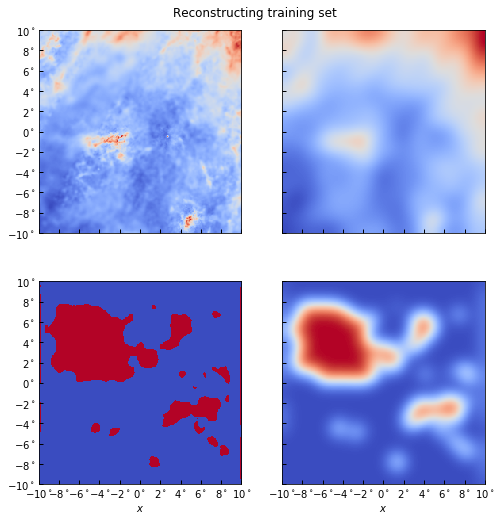

In [31]:
fig, axes = mplot(np.concatenate((x_train[None, ...], x_train_smo[None, ...], x_train_prediction[..., 0], x_train_prediction_smo[None, ...])), xlabels=[None, None, r"$x$", r"$x$"], extent=[-10, 10, -10, 10], title="Reconstructing training set")

In [24]:
print(opt.num_iterations)
print(opt.converged)
print(opt.position)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor([False], shape=(1,), dtype=bool)
tf.Tensor(
[[ 0.6574458   0.6514777   0.01227091  0.3348909   0.07002894  0.44685444
   1.6218047  -0.5342151  -0.516294   -0.48680103  0.62294644 -0.1589692
  -0.48237586  0.00454945 -0.67499024 -0.46666914 -0.5628408   0.59309196
  -0.13475442  1.705582   -0.04741585  0.94969237 -0.6585426  -0.30705652
   1.4716392   0.31968802 -1.2622776   0.6440051  -0.26725858 -0.3515566
  -0.07884595 -0.6508266  -0.25659984 -0.62245584 -0.70695555  0.13372478
   1.0503914  -0.36271572 -0.8276823  -0.34833702 -0.23126002 -0.1846022
  -0.8987436  -1.4509804   0.1092856   1.0279624   0.39444825  0.4336184
  -0.85227096  1.0553606   0.07426703  1.1087258   0.75463086 -1.8770391
   1.0683901  -0.64197403  0.1575579  -0.39589658  0.19895644 -0.16964951
   0.25972456  0.15022302  0.4356817  -0.40737045]], shape=(1, 64), dtype=float32)


In [71]:
def l2(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss_value = tf.linalg.norm(gen(x) - x_train)
    jac = tape.gradient(loss_value,x)
    loss_value = tf.reshape(loss_value, [1])
    return loss_value,jac

x = tf.Variable(np.random.randn(1, 64).astype(np.float32))
opt = tfp.optimizer.lbfgs_minimize(l2,initial_position = x, tolerance=1e-05, max_iterations=200)
x_train_prediction = gen(opt.position)
x_train_predictio_smo = gaussian_filter(x_train_prediction, sigma)

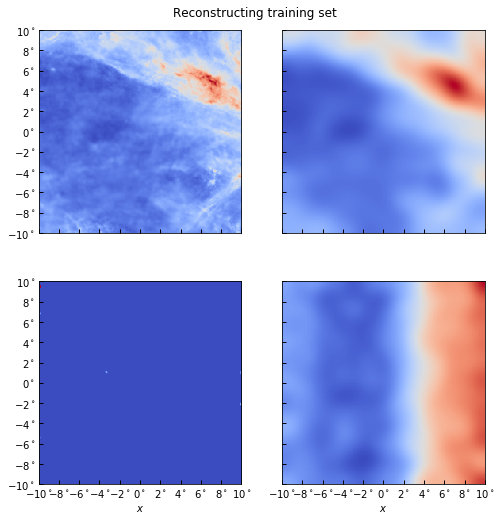

In [73]:
fig, axes = mplot(np.concatenate((x_train[None, ...], x_train_smo[None, ...], x_train_prediction[..., 0], x_train_prediction_smo[None, ...])), xlabels=[None, None, r"$x$", r"$x$"], extent=[-10, 10, -10, 10], title="Reconstructing training set")



In [20]:
import h5py

with h5py.File("/home/bthorne/projects/gan/began/data/preprocessed/Planck_dust_cuts_353GHz_norm_log_res256.h5", 'r') as f:
    kma = f['1'][:]

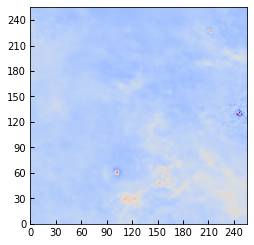

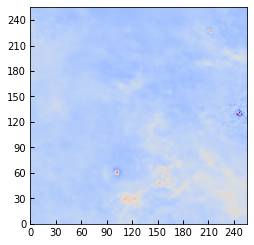

In [21]:
plot(kma)

In [22]:
import began
LAT_DIM = 128
vae_model = began.CVAE(LAT_DIM)


In [23]:
vae_model.load_weights('/home/bthorne/projects/gan/began/models/vae.h5')

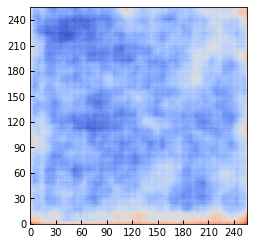

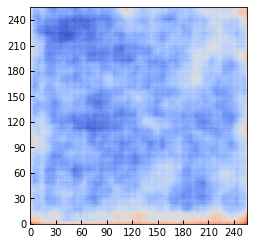

In [24]:
plot(vae_model.decode(np.random.randn(1, 128).astype(np.float32))[0, :, :, 0])

In [25]:
z_enc = vae_model.encode(x_train[None, :, :, None])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



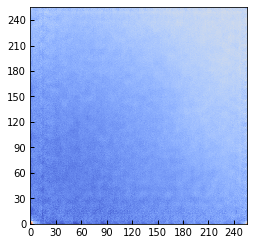

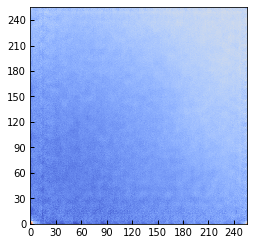

In [26]:
plot(vae_model.decode(z_enc)[0, :, :, 0])